## Ähnlichkeit Embeddings Positiv und Negativ im 10X Datensatz

In [ ]:
#import sys
#print(sys.executable)

In [4]:
#!{sys.executable} -m pip install pandas numpy scikit-learn matplotlib seaborn


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [3]:
def create_folders_if_not_exists(folders):
  for path in folders:
    if not os.path.exists(path):
      os.makedirs(path)


In [4]:
precision = 'allele'
pipeline_data = './data_10x'
pipeline_data_plain = f'{pipeline_data}/plain_datasets'
pipeline_data_cleaned = f'{pipeline_data}/cleaned_datasets'
pipeline_data_concatenated = f'{pipeline_data}/concatenated_datasets'
pipeline_data_splitted = f'{pipeline_data}/splitted_datasets'
pipeline_data_temp_bucket = f'{pipeline_data}/temp'

pipeline_folders = [pipeline_data, pipeline_data_plain, pipeline_data_cleaned, pipeline_data_concatenated, pipeline_data_splitted, pipeline_data_temp_bucket]

create_folders_if_not_exists(pipeline_folders)

In [14]:
# Laden von Embeddings für die "paired" Daten
tra_embeddings = np.load(f"{pipeline_data}/embeddings_old/paired/{precision}/TRA_paired_embeddings.npz")
trb_embeddings = np.load(f"{pipeline_data}/embeddings_old/paired/{precision}/TRB_paired_embeddings.npz")
epitope_embeddings = np.load(f"{pipeline_data}/embeddings_old/paired/{precision}/Epitope_paired_embeddings.npz")

In [13]:
'''# Anzeigen der Schlüssel in jeder Datei
print("Keys in TRA Embeddings:", tra_embeddings.keys())
print("Keys in TRB Embeddings:", trb_embeddings.keys())
print("Keys in Epitope Embeddings:", epitope_embeddings.keys())

# Die ersten 5 Zeilen der Werte für jeden Schlüssel anzeigen (beispielsweise für den ersten Schlüssel)
# Ersetzen Sie 'key_name' durch den tatsächlichen Namen eines Schlüssels in den Embeddings
for key in tra_embeddings.keys():
    print(f"\nFirst 5 rows for {key} in TRA Embeddings:")
    print(tra_embeddings[key][:5])

for key in trb_embeddings.keys():
    print(f"\nFirst 5 rows for {key} in TRB Embeddings:")
    print(trb_embeddings[key][:5])

for key in epitope_embeddings.keys():
    print(f"\nFirst 5 rows for {key} in Epitope Embeddings:")
    print(epitope_embeddings[key][:5])'''

'# Anzeigen der Schlüssel in jeder Datei\nprint("Keys in TRA Embeddings:", tra_embeddings.keys())\nprint("Keys in TRB Embeddings:", trb_embeddings.keys())\nprint("Keys in Epitope Embeddings:", epitope_embeddings.keys())\n\n# Die ersten 5 Zeilen der Werte für jeden Schlüssel anzeigen (beispielsweise für den ersten Schlüssel)\n# Ersetzen Sie \'key_name\' durch den tatsächlichen Namen eines Schlüssels in den Embeddings\nfor key in tra_embeddings.keys():\n    print(f"\nFirst 5 rows for {key} in TRA Embeddings:")\n    print(tra_embeddings[key][:5])\n\nfor key in trb_embeddings.keys():\n    print(f"\nFirst 5 rows for {key} in TRB Embeddings:")\n    print(trb_embeddings[key][:5])\n\nfor key in epitope_embeddings.keys():\n    print(f"\nFirst 5 rows for {key} in Epitope Embeddings:")\n    print(epitope_embeddings[key][:5])'

In [15]:
# Alle Dateien laden und zusammenführen
df_train = pd.read_csv('./data_10x/splitted_datasets/allele/paired/train.tsv', sep='\t')
df_val = pd.read_csv('./data_10x/splitted_datasets/allele/paired/validation.tsv', sep='\t')
df_test = pd.read_csv('./data_10x/splitted_datasets/allele/paired/test.tsv', sep='\t')
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Positive und negative Keys basierend auf der "Binding"-Spalte
positive_keys = df[df['Binding'] == 1]['TRB_CDR3'].tolist()
negative_keys = df[df['Binding'] == 0]['TRB_CDR3'].tolist()

# Extrahiere Embeddings für positive und negative Proben in Listen
positive_embeddings = [trb_embeddings[key] for key in positive_keys if key in trb_embeddings]
negative_embeddings = [trb_embeddings[key] for key in negative_keys if key in trb_embeddings]

# Überprüfen, ob genügend positive und negative Embeddings vorhanden sind
print(f"Anzahl positiver Embeddings: {len(positive_embeddings)}")
print(f"Anzahl negativer Embeddings: {len(negative_embeddings)}")

Anzahl positiver Embeddings: 52167
Anzahl negativer Embeddings: 114775


In [16]:
# Zufällige Stichprobe der Daten
sample_size = 10000  # Anzahl der positiven und negativen Embeddings für die Berechnung und Visualisierung
positive_embeddings_sample = random.sample(positive_embeddings, min(sample_size, len(positive_embeddings)))
negative_embeddings_sample = random.sample(negative_embeddings, min(sample_size, len(negative_embeddings)))

# Überprüfen der Länge aller Embeddings
embedding_lengths_pos = [embedding.shape[0] for embedding in positive_embeddings_sample]
embedding_lengths_neg = [embedding.shape[0] for embedding in negative_embeddings_sample]

print(f"Einzigartige Längen der positiven Embeddings: {set(embedding_lengths_pos)}")
print(f"Einzigartige Längen der negativen Embeddings: {set(embedding_lengths_neg)}")

Einzigartige Längen der positiven Embeddings: {6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25}
Einzigartige Längen der negativen Embeddings: {6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


Durchschnittliche Cosinus-Ähnlichkeit zwischen positiven und negativen Samples: 0.8244503736495972


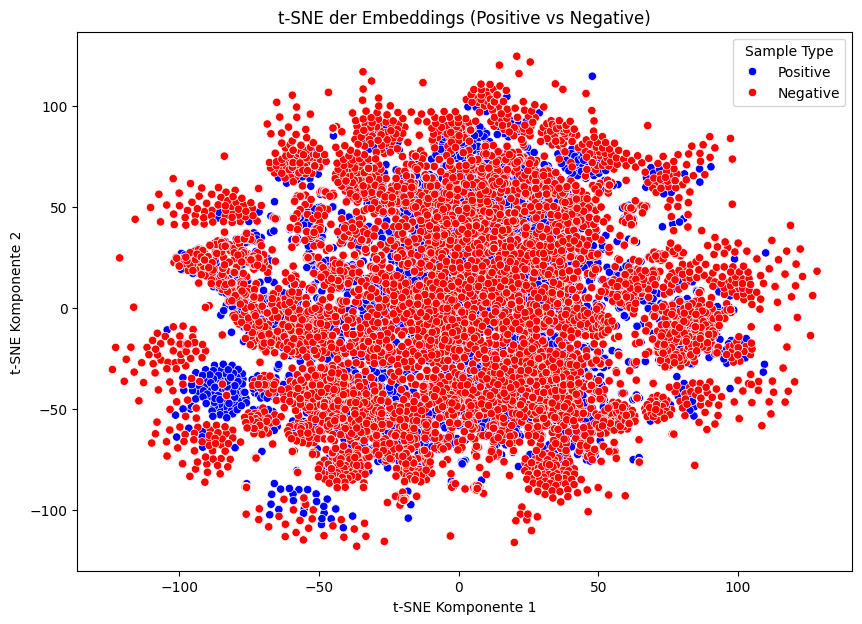

In [17]:
# Maximale Länge bestimmen
max_length = 26

# Funktion zum Padding oder Truncating von Embeddings
def pad_or_truncate_embedding(embedding, max_length):
    if len(embedding) < max_length:
        padding = max_length - len(embedding)
        embedding = np.pad(embedding, ((0, padding), (0, 0)), mode='constant')
    return embedding[:max_length]  # Falls Embedding zu lang, wird es abgeschnitten

# Padding/Truncating der Embeddings
positive_embeddings_sample = np.array([pad_or_truncate_embedding(embedding, max_length) for embedding in positive_embeddings_sample])
negative_embeddings_sample = np.array([pad_or_truncate_embedding(embedding, max_length) for embedding in negative_embeddings_sample])

# Flattening: Mittelwertbildung über die Sequenzdimension (Dim 0)
positive_embeddings_flat = np.mean(positive_embeddings_sample, axis=1)
negative_embeddings_flat = np.mean(negative_embeddings_sample, axis=1)

# Cosinus-Ähnlichkeit batchweise berechnen
batch_size = 1000  # Größe des Batches
similarities = []
for i in range(0, len(positive_embeddings_flat), batch_size):
    batch_positive = positive_embeddings_flat[i:i + batch_size]
    for j in range(0, len(negative_embeddings_flat), batch_size):
        batch_negative = negative_embeddings_flat[j:j + batch_size]
        # Cosinus-Ähnlichkeit für den Batch berechnen
        batch_similarity = cosine_similarity(batch_positive, batch_negative)
        similarities.append(batch_similarity)

# Durchschnittliche Cosinus-Ähnlichkeit berechnen
average_similarity = np.mean([np.mean(batch) for batch in similarities])
print(f"Durchschnittliche Cosinus-Ähnlichkeit zwischen positiven und negativen Samples: {average_similarity}")

# t-SNE-Visualisierung der Embeddings
all_embeddings = np.vstack([positive_embeddings_flat, negative_embeddings_flat])
labels = ['Positive'] * len(positive_embeddings_flat) + ['Negative'] * len(negative_embeddings_flat)

# t-SNE ausführen
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot der t-SNE-Ergebnisse
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=['blue', 'red'])
plt.title('t-SNE der Embeddings (Positive vs Negative)')
plt.xlabel('t-SNE Komponente 1')
plt.ylabel('t-SNE Komponente 2')
plt.legend(title='Sample Type')
plt.show()


## Ähnlichkeit Embeddings Positiv und Negativ von BA

In [5]:
precision = 'allele'
pipeline_data = './../../BA/BA_ZHAW/data'
pipeline_data_plain = f'{pipeline_data}/plain_datasets'
pipeline_data_cleaned = f'{pipeline_data}/cleaned_datasets'
pipeline_data_concatenated = f'{pipeline_data}/concatenated_datasets'
pipeline_data_splitted = f'{pipeline_data}/splitted_datasets'
pipeline_data_temp_bucket = f'{pipeline_data}/temp'

pipeline_folders = [pipeline_data, pipeline_data_plain, pipeline_data_cleaned, pipeline_data_concatenated, pipeline_data_splitted, pipeline_data_temp_bucket]

create_folders_if_not_exists(pipeline_folders)

In [6]:
# Laden von Embeddings für die "paired" Daten
tra_embeddings = np.load(f"{pipeline_data}/embeddings/paired/{precision}/TRA_paired_embeddings.npz")
trb_embeddings = np.load(f"{pipeline_data}/embeddings/paired/{precision}/TRB_paired_embeddings.npz")
epitope_embeddings = np.load(f"{pipeline_data}/embeddings/paired/{precision}/Epitope_paired_embeddings.npz")

In [7]:
# Alle Dateien laden und zusammenführen
df_train = pd.read_csv('./../../BA/BA_ZHAW/data/splitted_datasets/allele/paired/train.tsv', sep='\t')
df_val = pd.read_csv('./../../BA/BA_ZHAW/data/splitted_datasets/allele/paired/validation.tsv', sep='\t')
df_test = pd.read_csv('./../../BA/BA_ZHAW/data/splitted_datasets/allele/paired/test.tsv', sep='\t')
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Positive und negative Keys basierend auf der "Binding"-Spalte
positive_keys = df[df['Binding'] == 1]['TRB_CDR3'].tolist()
negative_keys = df[df['Binding'] == 0]['TRB_CDR3'].tolist()

# Extrahiere Embeddings für positive und negative Proben in Listen
positive_embeddings = [trb_embeddings[key] for key in positive_keys if key in trb_embeddings]
negative_embeddings = [trb_embeddings[key] for key in negative_keys if key in trb_embeddings]

# Überprüfen, ob genügend positive und negative Embeddings vorhanden sind
print(f"Anzahl positiver Embeddings: {len(positive_embeddings)}")
print(f"Anzahl negativer Embeddings: {len(negative_embeddings)}")

Anzahl positiver Embeddings: 52167
Anzahl negativer Embeddings: 51673


In [8]:
# Zufällige Stichprobe der Daten
sample_size = 10000  # Anzahl der positiven und negativen Embeddings für die Berechnung und Visualisierung
positive_embeddings_sample = random.sample(positive_embeddings, min(sample_size, len(positive_embeddings)))
negative_embeddings_sample = random.sample(negative_embeddings, min(sample_size, len(negative_embeddings)))

# Überprüfen der Länge aller Embeddings
embedding_lengths_pos = [embedding.shape[0] for embedding in positive_embeddings_sample]
embedding_lengths_neg = [embedding.shape[0] for embedding in negative_embeddings_sample]

print(f"Einzigartige Längen der positiven Embeddings: {set(embedding_lengths_pos)}")
print(f"Einzigartige Längen der negativen Embeddings: {set(embedding_lengths_neg)}")

Einzigartige Längen der positiven Embeddings: {6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
Einzigartige Längen der negativen Embeddings: {6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


Durchschnittliche Cosinus-Ähnlichkeit zwischen positiven und negativen Samples: 0.8257268667221069


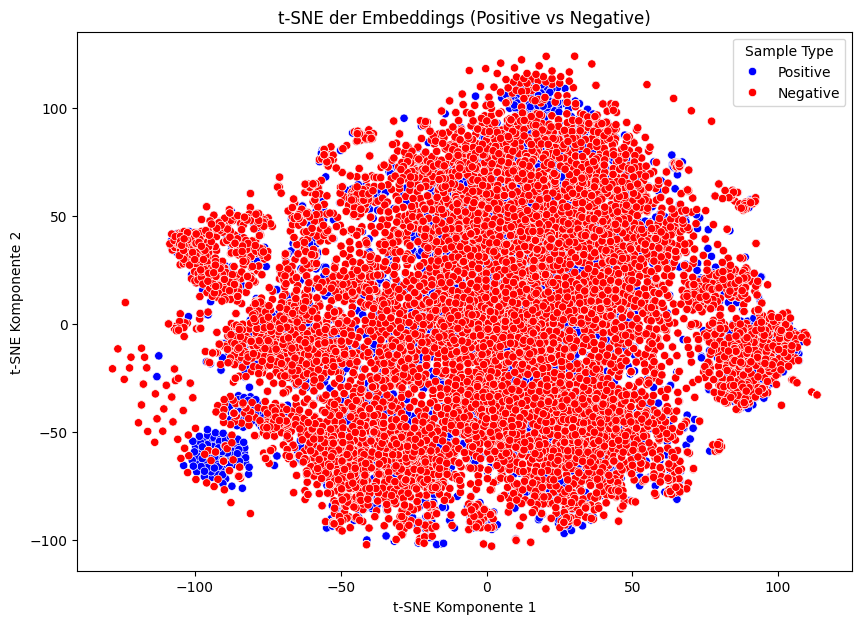

In [9]:
# Maximale Länge bestimmen
max_length = 26

# Funktion zum Padding oder Truncating von Embeddings
def pad_or_truncate_embedding(embedding, max_length):
    if len(embedding) < max_length:
        padding = max_length - len(embedding)
        embedding = np.pad(embedding, ((0, padding), (0, 0)), mode='constant')
    return embedding[:max_length]  # Falls Embedding zu lang, wird es abgeschnitten

# Padding/Truncating der Embeddings
positive_embeddings_sample = np.array([pad_or_truncate_embedding(embedding, max_length) for embedding in positive_embeddings_sample])
negative_embeddings_sample = np.array([pad_or_truncate_embedding(embedding, max_length) for embedding in negative_embeddings_sample])

# Flattening: Mittelwertbildung über die Sequenzdimension (Dim 0)
positive_embeddings_flat = np.mean(positive_embeddings_sample, axis=1)
negative_embeddings_flat = np.mean(negative_embeddings_sample, axis=1)

# Cosinus-Ähnlichkeit batchweise berechnen
batch_size = 1000  # Größe des Batches
similarities = []
for i in range(0, len(positive_embeddings_flat), batch_size):
    batch_positive = positive_embeddings_flat[i:i + batch_size]
    for j in range(0, len(negative_embeddings_flat), batch_size):
        batch_negative = negative_embeddings_flat[j:j + batch_size]
        # Cosinus-Ähnlichkeit für den Batch berechnen
        batch_similarity = cosine_similarity(batch_positive, batch_negative)
        similarities.append(batch_similarity)

# Durchschnittliche Cosinus-Ähnlichkeit berechnen
average_similarity = np.mean([np.mean(batch) for batch in similarities])
print(f"Durchschnittliche Cosinus-Ähnlichkeit zwischen positiven und negativen Samples: {average_similarity}")

# t-SNE-Visualisierung der Embeddings
all_embeddings = np.vstack([positive_embeddings_flat, negative_embeddings_flat])
labels = ['Positive'] * len(positive_embeddings_flat) + ['Negative'] * len(negative_embeddings_flat)

# t-SNE ausführen
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Plot der t-SNE-Ergebnisse
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels, palette=['blue', 'red'])
plt.title('t-SNE der Embeddings (Positive vs Negative)')
plt.xlabel('t-SNE Komponente 1')
plt.ylabel('t-SNE Komponente 2')
plt.legend(title='Sample Type')
plt.show()
